# Modeliranje 1-D porazdelitve: razpadi Higgsovega bozona

# 2. del

Repozitorij naloge: https://github.com/j-gavran/PSUF_Hmumu

## 1. naloga: Praktikum strojnega učenja v fiziki 2025/26

**predavatelj**: [prof. dr. Borut Paul Kerševan](mailto:borut.kersevan@ijs.si)  
**asistent**: [Jan Gavranovič](mailto:jan.gavranovic@ijs.si)

# Scikit-learn in Gaussovski procesi

- Pri nalogi bomo uporabili implementacijo GPR iz knjižnice scikit-learn.
- Obstajajo tudi druge:
    - [GPyTorch](https://github.com/jwangjie/gpytorch) (PyTorch),
    - [GPflow](https://github.com/GPflow/GPflow) (Tensorflow),
    - [GPJax](https://github.com/JaxGaussianProcesses/GPJax) (JAX),
    - [GPy](https://github.com/SheffieldML/GPy) (Python)

- Za zgled si bomo ogledali modeliranje točk iz $f(x) = x \sin (x)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

In [2]:
n = 1000 # number of training and testing points

X = np.linspace(0.0, 10.0, n).reshape(-1, 1) # column vector 
y = np.squeeze(X * np.sin(X)) # points from true function

- Podatke razdelimo na učno in testno množico.
- Za učenje bomo uporabili 1% vseh točk.
- Vrednostim bomo dodali še Gaussovski šum z amplitudo $\sigma$.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, shuffle=True)

noise_std = 0.75
y_train_noisy = y_train + np.random.normal(loc=0.0, scale=noise_std, size=y_train.shape)

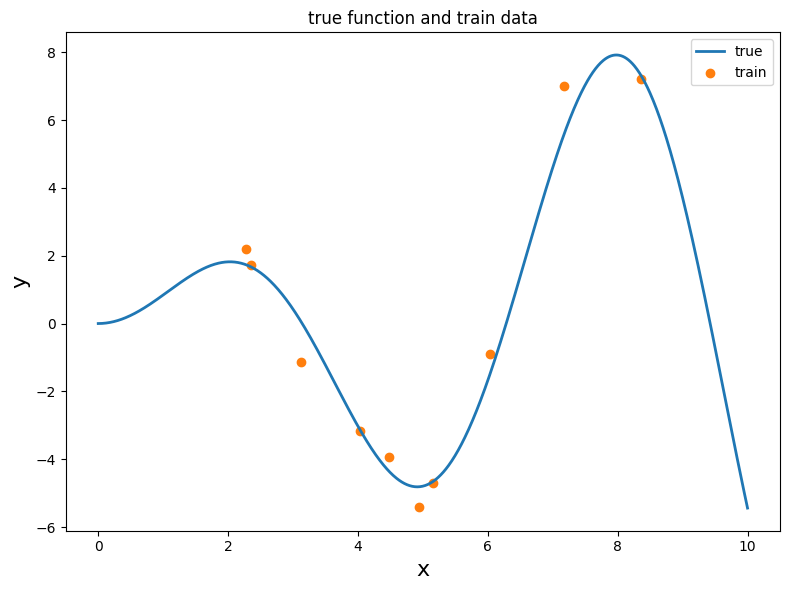

In [4]:
plt.figure(figsize=(8, 6))

plt.plot(X, y, lw=2, label="true")
plt.scatter(X_train, y_train_noisy, c="C1", label="train")

plt.title("true function and train data")
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.legend(fontsize=10)

plt.tight_layout()

- Definiramo jedro in GPR model.
- Parameter $\alpha$ interpretiramo kot varianco Gaussovskega šuma vhodnih podatkov (merske napake!).

In [5]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=10)

- Na modelu kličemo `fit` funkcijo na učnih podatkih.

In [6]:
gaussian_process.fit(X_train, y_train_noisy)

,kernel,1**2 * RBF(length_scale=1)
,alpha,0.5625
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,1**2
,kernel__k2,RBF(length_scale=1)
,kernel__k1__constant_value,1.0


- Model optimizira tudi parametra $\sigma^2$ in $\ell$ jedra RBF.

In [7]:
gaussian_process.kernel_

4.9**2 * RBF(length_scale=1.43)

- Za napovedovanje novih vrednosti na testnih podatkih uporabimo `predict`.

In [8]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

In [9]:
# flatten for plotting
X_train, X_test = X_train.flatten(), X_test.flatten()
mean_prediction, std_prediction = mean_prediction.flatten(), std_prediction.flatten()

In [10]:
# sort for plotting
idx = np.argsort(X_test)
X_test, mean_prediction, std_prediction = X_test[idx], mean_prediction[idx], std_prediction[idx]

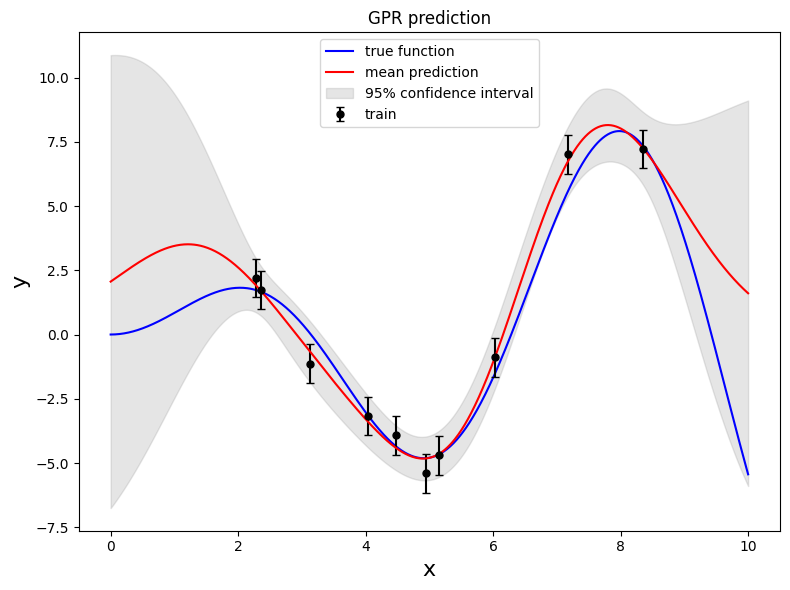

In [11]:
plt.figure(figsize=(8, 6))

plt.plot(X, y, "b-", label="true function")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="k",
    marker=".",
    markersize=10,
    label="train",
    capsize=3,
)
plt.plot(X_test, mean_prediction, label="mean prediction", c="r")
plt.fill_between(
    X_test,
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="gray",
    alpha=0.2,
    label=r"95% confidence interval",
)

plt.title("GPR prediction")
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.legend(fontsize=10)

plt.tight_layout()

## Iskanje optimalnih parametrov jedra

- Poiskali bomo najboljša parametra $\sigma^2$ in $\ell$ našega jedra RBF.
- Izračunali bomo $\log p(\vec{y}|X)$ pri različnih vrednostih teh parametrov in poiskali maksimum.
- Bolj učinkovit način bi bil z uporabe kakšne od gradientnih metod.

In [12]:
# make a log grid search space
length_scale = np.logspace(-3, 3, 100)
noise_level = np.logspace(-3, 3, 100)

In [13]:
# do grid scan and calculate mll at each point
mll_results = np.empty((len(length_scale), len(noise_level)))

for i, scale in enumerate(length_scale):
    for j, noise in enumerate(noise_level):
        mll_results[i, j] = - gaussian_process.log_marginal_likelihood(theta=np.log([scale, noise]))

In [14]:
# find the smallest element in mll
idx = np.unravel_index(np.argmin(mll_results), mll_results.shape)
best_noise_level, best_length_scale = length_scale[idx[0]], noise_level[idx[1]]

best_noise_level, best_length_scale

(np.float64(23.10129700083158), np.float64(1.4174741629268048))

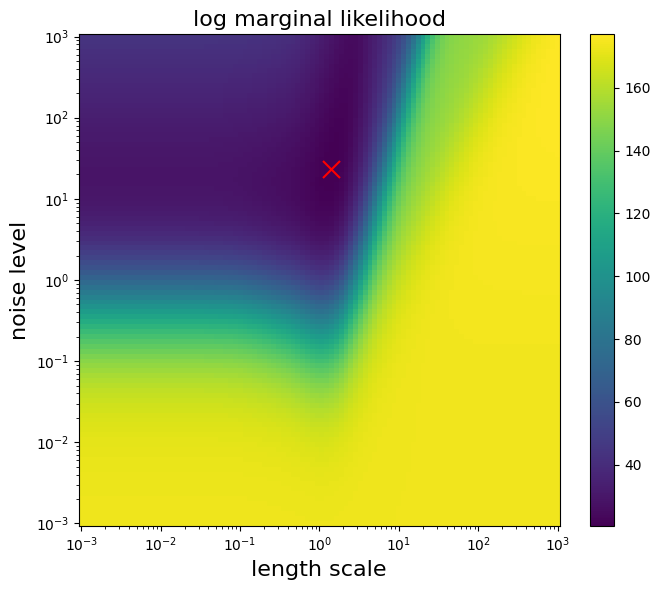

In [15]:
plt.figure(figsize=(7, 6))

plt.pcolormesh(length_scale, noise_level, mll_results)
plt.colorbar()

plt.scatter(best_length_scale, best_noise_level, marker="x", s=150, c="r")

plt.yscale("log")
plt.xscale("log")

plt.xlabel("length scale", fontsize=16)
plt.ylabel("noise level", fontsize=16)
plt.title("log marginal likelihood", fontsize=16)

plt.tight_layout()

## Uporaba različnih jeder

- V scikit-learn je na voljo več različnih jeder.
- Jedra lahko med sabo tudi kombiniramo:
    - $k(\vec{x}, \vec{x}^\prime) = c k_1(\vec{x}, \vec{x}^\prime)$ za konstanto $c>0$,
    - $k(\vec{x}, \vec{x}^\prime) = f(\vec{x})k_1(\vec{x}, \vec{x}^\prime)f(\vec{x}^\prime)$ za neko funkcijo $f$,
    - $k(\vec{x}, \vec{x}^\prime) = q(k_1(\vec{x}, \vec{x}^\prime))$ za polinom $q$ s pozitivnimi koeficienti,
    - $k(\vec{x}, \vec{x}^\prime) = \exp(k_1(\vec{x}, \vec{x}^\prime))$,
    - $k(\vec{x}, \vec{x}^\prime) = \vec{x}^\top A \vec{x}^\prime$ za pozitivno semi deifnitno matriko $A$,
    - $k(\vec{x}, \vec{x}^\prime) = k_1(\vec{x}, \vec{x}^\prime) + k_2(\vec{x}, \vec{x}^\prime)$,
    - $k(\vec{x}, \vec{x}^\prime) = k_1(\vec{x}, \vec{x}^\prime) \cdot k_2(\vec{x}, \vec{x}^\prime)$.
- Glej https://www.cs.toronto.edu/~duvenaud/cookbook/. 

In [16]:
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel, DotProduct, Matern

In [17]:
f_model = lambda x: np.sin((x - 2.5)**2)

np.random.seed(12)

X_train = np.random.uniform(0, 5, 10).reshape(-1, 1)
y_train = f_model(X_train[:, 0])

X_test = np.linspace(0, 5, 100).reshape(-1, 1)
y_true = f_model(X_test[:, 0])

In [18]:
kernels = {
    "RBF": 1.0 * RBF(
        length_scale=1.0,
        length_scale_bounds=(1e-1, 10.0),
    ),
    "RationalQuadratic": 1.0 * RationalQuadratic(
        length_scale=1.0,
        alpha=0.1,
        alpha_bounds=(1e-5, 1e15),
    ),
    "ExpSineSquared": 1.0 * ExpSineSquared(
        length_scale=1.0,
        periodicity=3.0,
        length_scale_bounds=(0.1, 10.0),
        periodicity_bounds=(1.0, 10.0),
    ),
    "DotProduct": ConstantKernel(
        constant_value=0.1,
        constant_value_bounds=(0.01, 10.0),
    )
    * DotProduct(
        sigma_0=1.0,
        sigma_0_bounds=(0.1, 10.0),
    ) ** 2,
    "Matern": 1.0 * Matern(
        length_scale=1.0,
        length_scale_bounds=(1e-1, 10.0),
        nu=1.5,
    ),
}

/Users/jan/repositories/PSUF_Hmumu/psuf-venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/jan/repositories/PSUF_Hmumu/psuf-venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/jan/repositories/PSUF_Hmumu/psuf-venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 2 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

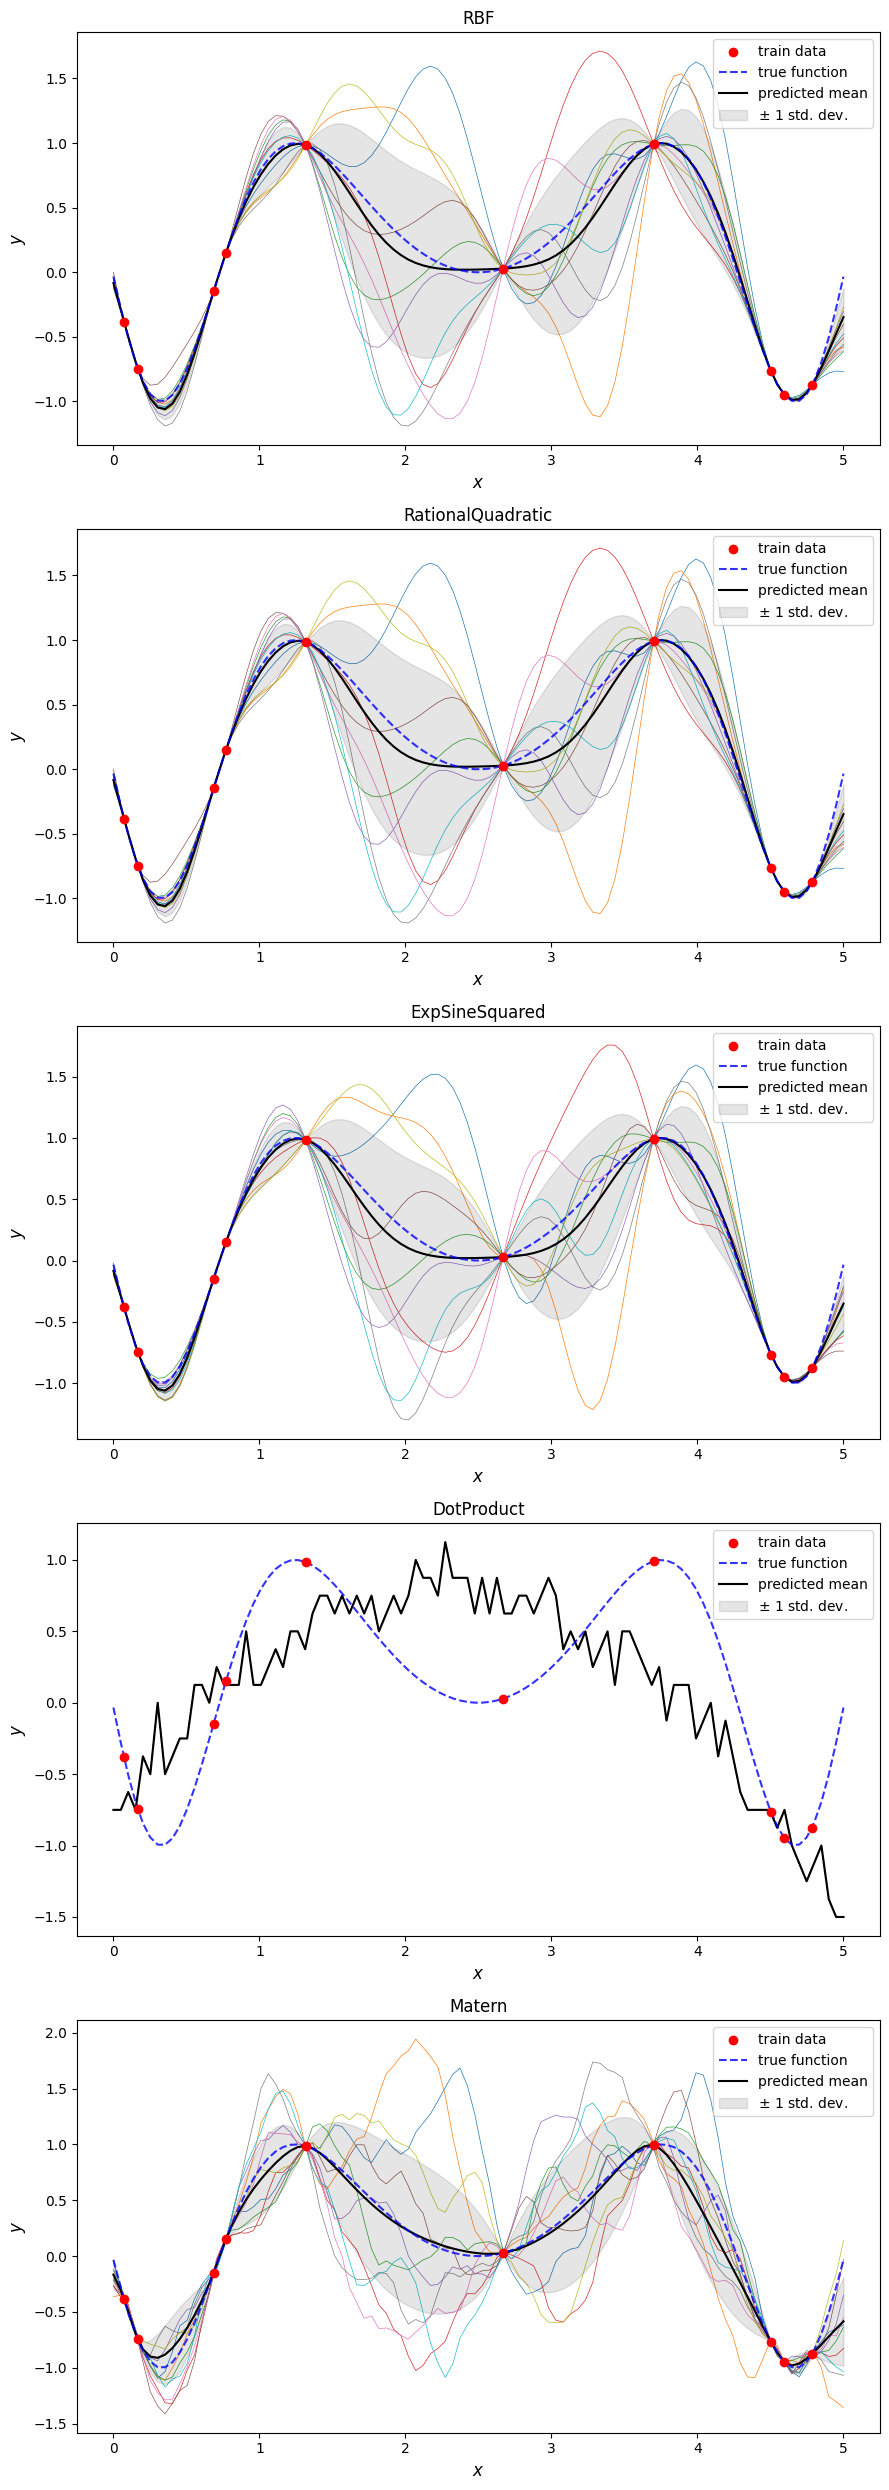

In [19]:
fig, axs = plt.subplots(len(kernels), figsize=(9, 5 * len(kernels)))

for i, (name, kernel) in enumerate(kernels.items()):
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gpr_model.fit(X_train, y_train)

    y_mean, y_std = gpr_model.predict(X_test, return_std=True)
    y_samples = gpr_model.sample_y(X_test, n_samples=10)

    axs[i].scatter(X_train[:, 0], y_train, c="r", label="train data", zorder=3)
    axs[i].plot(X_test[:, 0], y_true, c="b", ls="--", alpha=0.8, label="true function", zorder=2)
    axs[i].plot(X_test[:, 0], y_mean, color="k", label="predicted mean", zorder=1)
    axs[i].plot(X_test[:, 0], y_samples, lw=0.5, zorder=0)
    axs[i].fill_between(
        X_test[:, 0],
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    axs[i].set_xlabel(r"$x$", fontsize=12)
    axs[i].set_ylabel(r"$y$", fontsize=12)
    axs[i].set_title(name)
    axs[i].legend(loc="upper right")

fig.tight_layout()

# Reševanje 2. dela naloge

In [20]:
%cd ..

/Users/jan/repositories/PSUF_Hmumu


In [21]:
from helpers.create_histograms import load_histogram
from helpers.visualize_data import plot_simple_histogram

In [22]:
# load already made histograms with some cut on m_mumu
path_to_hist = "data/generated_histograms"
hist_name = "my_hist"
hist_labels = ["Background", "Signal", "Data"]

hists = {}

for hist_label in hist_labels:
    hists[hist_label] = load_histogram(path_to_hist, hist_name, hist_label)

## Podatkovna množica Asimova

- Da dobimo signal $y(x_k)$, odštejemo podatke od fitanega ozadja:
$$
y(x_k)=d(x_k) - b(x_k) \>.
$$
- Na ta signal $y(x_k)$ prilagodimo funkcijo $\alpha \cdot$CB (proste parametre smo dobili že na simulaciji signala $s(x_k)$).
- Izmerjenega signala je v podatkih zelo malo $\Rightarrow$ postopek preizkusimo z napihnjenim signalom (*Asimov dataset*).
- Podatkom prištejemo MC signal:
$$
d_{A}(x_k) = d(x_k) + \gamma \cdot s(x_k) \>,
$$
kjer je $\gamma \geq 0$ nek faktor.

In [23]:
gamma = 10.0

d_bin_centers, d_bin_edges, d_bin_values, d_bin_errors = hists["Data"]
s_bin_centers, s_bin_edges, s_bin_values, s_bin_errors = hists["Signal"]

hists["AsimovData"] = [
    d_bin_centers,
    d_bin_edges,
    d_bin_values + gamma * s_bin_values,
    np.sqrt(d_bin_errors ** 2 + (gamma * s_bin_errors) ** 2)
]
hists["AsimovSignal"] = [
    s_bin_centers,
    s_bin_edges,
    s_bin_values + gamma * s_bin_values,
    s_bin_errors if gamma == 0.0 else gamma * s_bin_errors,
]

## Izključitev signalnega območja

- Simulacija ozadja ni vedno najboljša.
- Za oceno ozadja vzamemo izmerjene podatke, pri tem je potrebno izključiti območje, kjer pričakujemo signal (*blinding*).
- Izključimo npr. interval $m_{\mu\mu} = [120, 130]$ GeV, kjer pričakujemo signal.
- Na tem ozadju (*background from data*) naredimo fit in dobimo vrednosti $b(x_k)$.

In [24]:
# get histogram data
blind_hists = ["Data", "AsimovData"]

for hist_name in blind_hists:
    bin_centers, bin_edges, bin_values, bin_errors = hists[hist_name]
    
    blind_centers_m = (bin_centers <= 120.0) | (bin_centers >= 130.0) # bool mask for centers
    blind_edges_m = (bin_edges <= 120.0) | (bin_edges > 130.0) # bool mask for edges
    
    # make new dict entry 
    hists[f"Blind{hist_name}"] = [
        bin_centers[blind_centers_m],
        bin_edges[blind_edges_m],
        bin_values[blind_centers_m],
        bin_errors[blind_centers_m],
    ]

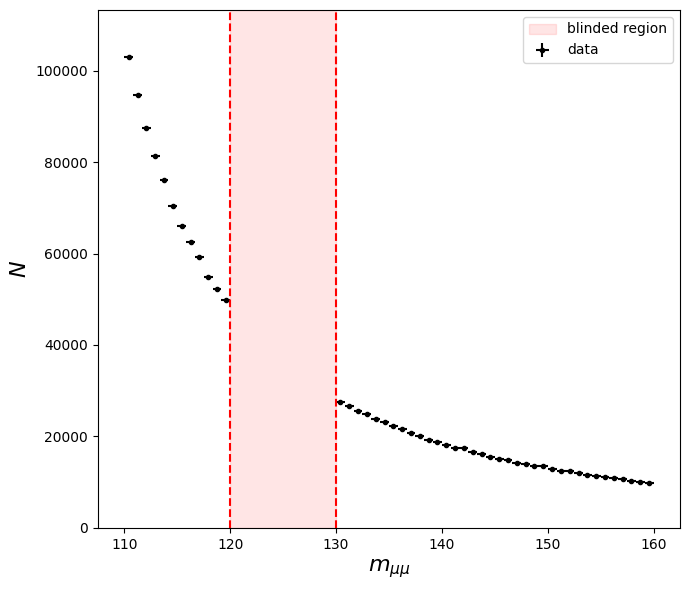

In [25]:
plt.figure(figsize=(7, 6))

centers, edges, values, errors = hists["BlindData"]

plt.errorbar(
    x=centers,
    y=values,
    xerr=np.diff(edges)[0] / 2,
    yerr=errors,
    linestyle="None",
    marker="o",
    ms=3,
    c="k",
    label="data",
)
plt.axvline(120.0, c="r", ls="--")
plt.axvline(130.0, c="r", ls="--")

max_height = 1.1 * np.max(values)
plt.fill_between([120.0, 130], 0.0, max_height, color="r", alpha=0.1, label="blinded region")
plt.ylim(0.0, max_height)

plt.xlabel(r"$m_{\mu\mu}$", fontsize=16)
plt.ylabel(r"$N$", fontsize=16)
plt.legend()

plt.tight_layout()

In [26]:
b_bin_centers, b_bin_edges, b_bin_values, b_bin_errors = hists["Background"]
s_bin_centers, s_bin_edges, s_bin_values, s_bin_errors = hists["Signal"]

hists["SignalPlusBackgroundMC"] = [
    b_bin_centers,
    b_bin_edges,
    b_bin_values + s_bin_values,
    np.sqrt(b_bin_errors ** 2 + s_bin_errors ** 2),
]

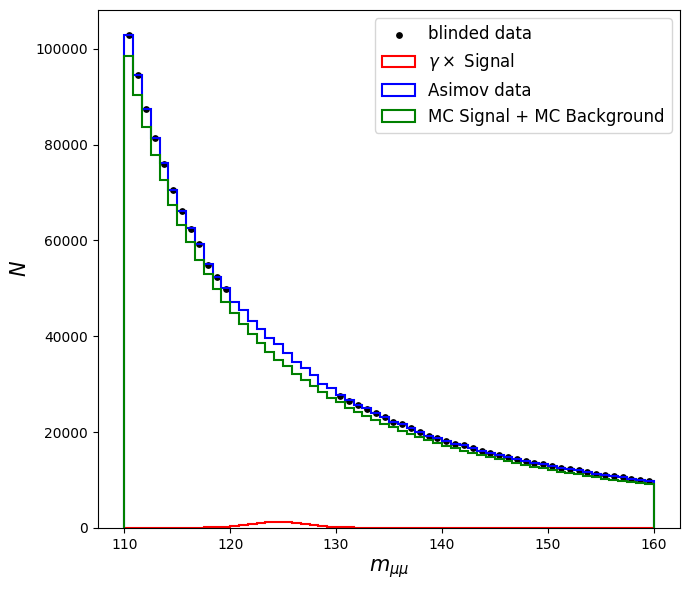

In [27]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(hists["BlindData"][0], hists["BlindData"][2], c="k", s=15, label="blinded data")
ax = plot_simple_histogram(ax, hists["AsimovSignal"], color="r", label=r"$\gamma \times$ Signal", lw=1.5)
ax = plot_simple_histogram(ax, hists["AsimovData"], color="b", label="Asimov data", lw=1.5)
ax = plot_simple_histogram(ax, hists["SignalPlusBackgroundMC"], color="g", label="MC Signal + MC Background", lw=1.5)

ax.set_xlabel(r"$m_{\mu\mu}$", fontsize=15)
ax.set_ylabel("$N$", fontsize=15)
ax.legend(fontsize=12)

fig.tight_layout()

## Predprocesiranje podatkov

- ML algoritmi ne delujejo dobro, če so vhodne številske vrednosti na različnih skalah.
- Pred učenjem algoritmov vedno naredimo normalizacijo podatkov (*feature scaling*).
- Najbolj pogosti sta:
    - min-max normalziacija $ x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$,
    - standardizacija $x_{\text{norm}} = \frac{x - \mu}{\sigma}$.
- Transfomacije morajo imeti tudi inverz.
- Razmisli kaj je z napakami, pomagaš si lahko s knjižnico [uncertainties](https://pythonhosted.org/uncertainties/).
- Za zgled bomo uporabili transformacijo podatkov z $\log$.

## Fitanje GPR na podatke

In [28]:
# library for error propagation on numpy arrays
from uncertainties import unumpy as unp

In [29]:
# get input data
bin_centers, bin_edges, bin_values, bin_errors = hists["AsimovData"]
b_bin_centers, b_bin_edges, b_bin_values, b_bin_errors = hists["BlindAsimovData"]

In [30]:
# preprocess X
X_train = b_bin_centers.reshape(-1, 1)
X_train = np.log(X_train)

In [31]:
# preprocess y
y_train = unp.uarray(b_bin_values, b_bin_errors)
y_train = unp.log(y_train)
y_train, y_train_var = unp.nominal_values(y_train), unp.std_devs(y_train)**2

In [32]:
# define kernel and model
kernel_rbf = ConstantKernel(
    1.0,
    constant_value_bounds=(1e-3, 1e3),
) * RBF(
    length_scale=1.0,
    length_scale_bounds=(1e-3, 1e3),
)

kernel_matern = ConstantKernel(
    1.0,
    constant_value_bounds=(1e-3, 1e3),
) * Matern(
    1.0,
    length_scale_bounds=(1e-3, 1e3),
    nu=1.5,
)

gpr_model = GaussianProcessRegressor(kernel=kernel_matern, alpha=y_train_var, n_restarts_optimizer=0)

In [33]:
# fit the model
gpr_model.fit(X_train, y_train)

# optimized kernel parameters
gpr_model.kernel_

21.7**2 * Matern(length_scale=7.29, nu=1.5)

In [34]:
# define test interval data with same scaling as inputs
X_test = bin_centers.reshape(-1, 1)
X_test = np.log(X_test)

# run predict on model
y_mean, y_std = gpr_model.predict(X_test, return_std=True)

In [35]:
# rescale back from log
X_train = np.exp(X_train)
y_train = np.exp(y_train)

X_test = np.exp(X_test)

y = unp.uarray(y_mean, y_std)
y = unp.exp(y)
y_mean, y_std = unp.nominal_values(y), unp.std_devs(y)

In [36]:
# save results to hists dict
hists["gpr"] = [X_test[:, 0], bin_edges, y_mean, y_std]

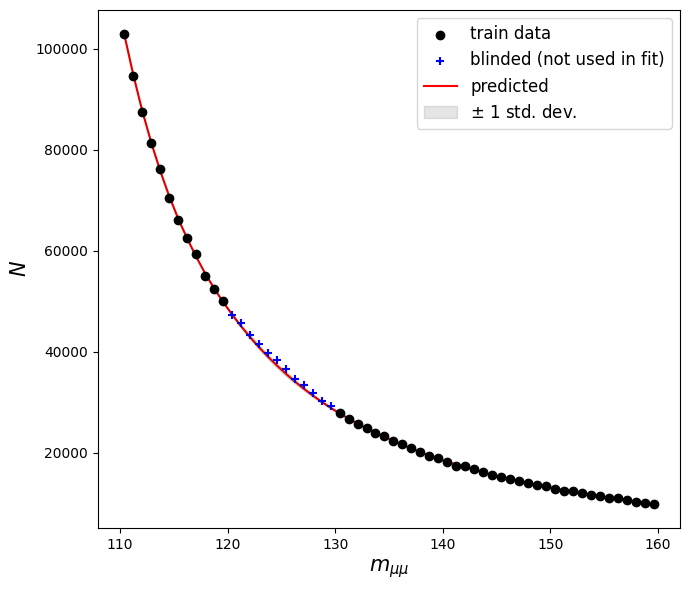

In [37]:
plt.figure(figsize=(7, 6))

plt.scatter(X_train[:, 0], y_train, c="k", label="train data", zorder=2)
plt.scatter(bin_centers, bin_values, c="b", marker="+", label="blinded (not used in fit)", zorder=1)
plt.plot(X_test[:, 0], y_mean, c="r", label="predicted", zorder=0)
plt.fill_between(
    X_test[:, 0],
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)

plt.xlabel(r"$m_{\mu\mu}$", fontsize=15)
plt.ylabel(r"$N$", fontsize=15)
plt.legend(fontsize=12)

plt.tight_layout()

- Cilj: preizkusi `GaussianProcessRegressor` za glajenje ozadja iz podatkov.
- Preberi dokumentacijo in preizkusi kodo, poskusi razumeti posamezne dele.
- Prepričaj se, da je dodajanje in kombiniranje kernelov v scikit-learn preprosto (RBF, Matern, ...).
- Uporabiš lahko tudi *Gibbsov kernel*, ki ga ni v knjižnici.
- Gibbsov kernel je v svojem bistvu RBF kernel, le da se $\ell$ lahko spreminja z linearno funkcijo:
$$
L(x) = L_{\text{slope}}x + c \>.
$$
- Pazi kako pripraviš podatke (logaritem, minmax, ...) in kako se pri tem spremenijo napake.
- Namesto GPR lahko uporabiš tudi kakšno drugo metodo regresije omenjenih na predavanjih (npr. [KRR](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html), [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), ...)

## Podatki - ozadje

- Od podatkov bomo odšteli zglajen signal po binih in dobili signal.

In [38]:
data = hists["AsimovData"]
gpr_background = hists["gpr"]

signal_x, edges = data[0], data[1]

# do smooth background subtraction
signal = data[2] - gpr_background[2]

# calculate errors from subtraction
signal_std = np.sqrt(data[3]**2 + gpr_background[3]**2)

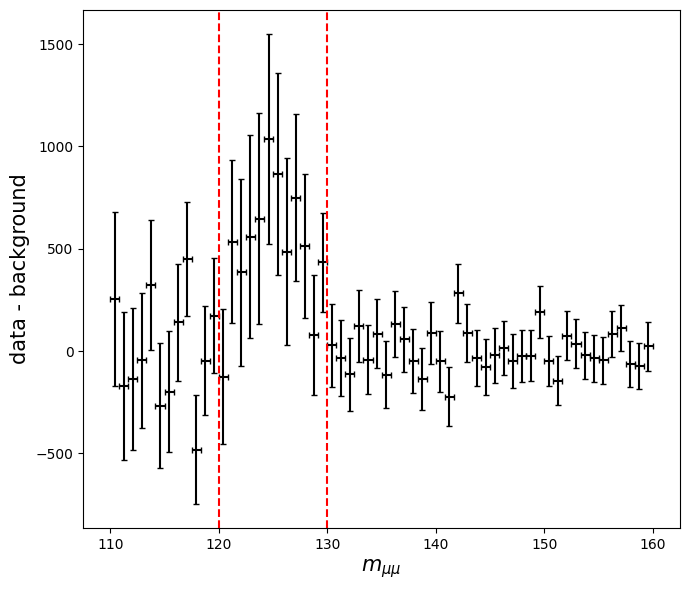

In [39]:
plt.figure(figsize=(7, 6))

plt.errorbar(
    x=signal_x,
    y=signal,
    xerr=np.diff(edges)[0] / 2,
    yerr=signal_std,
    linestyle="None",
    marker="o",
    ms=0,
    c="k",
    capsize=2,
)

plt.axvline(120.0, c="r", ls="--")
plt.axvline(130.0, c="r", ls="--")

plt.xlabel(r"$m_{\mu\mu}$", fontsize=15)
plt.ylabel("data - background", fontsize=15)

plt.tight_layout()

## Parametrizacija signala

- Na odšteto ozadje bomo sedaj fitali Crystal ball funkcijo z dodatnim skalirnim parametrom $\alpha$.

In [40]:
from scipy.optimize import curve_fit
from helpers.fit_CB import CrystalBall

In [41]:
# get CB parameter values for (Asimov) MC signal
bin_centers, bin_edges, bin_values, bin_errors = hists["AsimovSignal"]

popt_CB, pcov_CB = curve_fit(
    CrystalBall,
    bin_centers,
    bin_values,
    sigma=bin_errors,
    p0=np.array([133.0, 1.5, 1.5, 3.7, 9.6, 124.5, 3.0]),
)

/Users/jan/repositories/PSUF_Hmumu/helpers/fit_CB.py:20: RuntimeWarning: invalid value encountered in scalar power
  * (nR / np.abs(aR)) ** nR
/Users/jan/repositories/PSUF_Hmumu/helpers/fit_CB.py:22: RuntimeWarning: invalid value encountered in power
  * (nR / np.abs(aR) - np.abs(aR) + (x - mCB) / sCB) ** (-nR),
/Users/jan/repositories/PSUF_Hmumu/helpers/fit_CB.py:16: RuntimeWarning: invalid value encountered in scalar power
  * (nL / np.abs(aL)) ** nL


In [42]:
# define a class that acts as a function with MC signal CB parameters and scale parameter alpha
class ScaledParameterCrystalBall:
    def __init__(self, popt_CB):
        self.popt_CB = popt_CB

    def __call__(self, x, scale):
        return scale * CrystalBall(x, *self.popt_CB)

In [43]:
# fit CB with scale to data - background
scaled_param_CB = ScaledParameterCrystalBall(popt_CB)

alpha, alpha_var = curve_fit(
    scaled_param_CB,
    signal_x,
    signal,
    sigma=signal_std,
    p0=np.array([1.0]),
)
alpha, alpha_std = alpha[0], np.sqrt(alpha_var.ravel()[0])

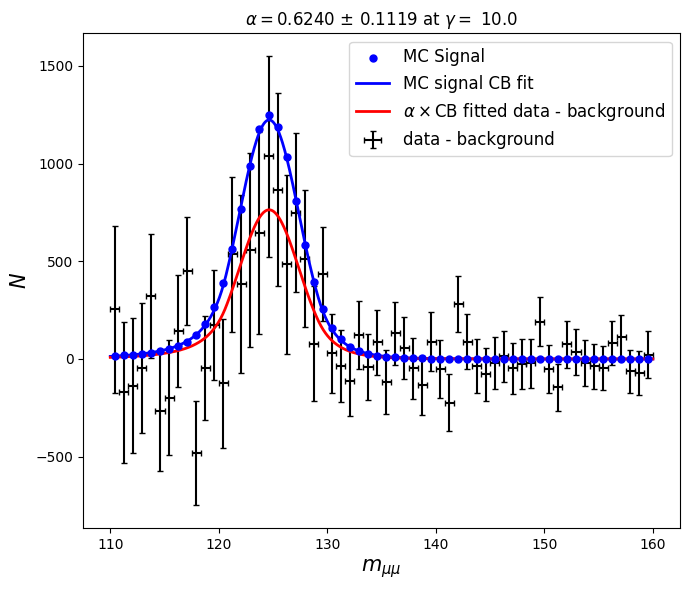

In [44]:
plt.figure(figsize=(7, 6))

plt.errorbar(
    x=signal_x,
    y=signal,
    xerr=np.diff(edges)[0] / 2,
    yerr=signal_std,
    linestyle="None",
    marker="o",
    ms=0,
    c="k",
    capsize=2,
    label="data - background",
)

plt.scatter(bin_centers, bin_values, c="b", marker="o", zorder=10, s=25, label="MC Signal")

x = np.linspace(110.0, 160.0, 1000)
plt.plot(x, CrystalBall(x, *popt_CB), c="b", lw=2, label="MC signal CB fit")
plt.plot(x, scaled_param_CB(x, alpha), color="r", lw=2, label=r"$\alpha \times$CB fitted data - background")

plt.xlabel(r"$m_{\mu\mu}$", fontsize=15)
plt.ylabel(r"$N$", fontsize=15)
plt.title(fr"$\alpha=${alpha:.4f} $\pm$ {alpha_std:.4f} at $\gamma=$ {gamma}")
plt.legend(fontsize=12)

plt.tight_layout()

## Po korakih še enkrat

1. **Pofitaj histogram simulacije signala (*simulated Higgs signal*):**
    - Uporabi nastavek za CB funkcijo.
    - Dobiš funkcijo $s(x_k)$ s parametri za MC signal.
2. **Pofitaj histogram simulacije ozadja (*simulated background*):**
    - Uporabi različne možnosti in intervale, ni ti treba izključiti območja signala (ker ga tu ni).
    - Dobiš funkcijo $m(x_k)$.
3. **Pofitaj histogram podatkov, da dobiš dobro oceno za ozadje (*background from data*):**
    - Moraš pa izključiti interval, kjer je v podatkih signal $\Rightarrow$ okno okrog $[120,130]$ GeV.
    - Uporabi različne možnosti, podobno kot na simulaciji ozadja $\Rightarrow$ razni funkcijski nastavki in ML metode.
    - Lahko vzameš tudi nastavek $q(x_k) m(x_k)$, kjer je $q(x_k)$ preprosta funkcija za fit in $m(x_k)$ pofitana na simulaciji ozadja.
    - Dobiš funkcijo $b(x_k)$.
4. **Odštej od podatkov čim bolje zglajeno ozadje.**
    - Če so podatki v binih $d_k(x)$, potem narediš $y(x_k)=d(x_k) - b(x_k)$.
5. **Na kar ostane (torej $y(x_k)$) nalepi parametrizacijo signala.**
    - Na funkcijo $s(x_k)$ dodaj parameter normalizacije/skaliranja $\alpha$, da dobiš $\alpha \cdot s(x_k)$.
    - Naredi fit na $y(x_k)$, da dobiš najboljšo oceno $\hat{\alpha}$ in njeno napako $\sigma_{\hat{\alpha}}$.
6. **Ponovi postopek za različne metode/parametre in vrednosti napihnjenega signala $d_A(x_k)=d(x_k) + \gamma \cdot s(x_k)$.**

<div>
    <img src="images/curve_fitting.png" width="400"/>
</div>

https://xkcd.com/2048/

# Priprava poročila

### Kako naj izgleda poročilo?

- Podobno kot modelska analiza in mafijski praktikum.
- Na nekaj straneh opišeš potek vaje in predstaviš rezultate, zanimive probleme in rešitve.
- Okvirno se držite navodil (točke 1-9).
- Cilj naloge je, da ste sami čim bolj inovativni:
    - preizkušate čim več načinov kako priti do rezultata,
    - ni tako pomembno, kakšni so rezultati,
    - štejejo vztrajnost in dobre ideje.
- Možnosti za analizo je ogromno, ocenite kaj se vam zdi smiselno preveriti in vključiti.
- Baseline ocena je 8 (rešiš vse naloge iz navodil, večina stvari dela že out of the box), vse dodatno (razmisleki, ideje, inovativni grafi, še kakšna metoda, ...) je 9 in 10.

### Oddaja poročila

- **Rok za oddajo: petek 17.10 do 13:00 popoldne.**
- Obvezno: pdf format. 
- Ime datoteke: psuf_naloga1_Ime_Priimek.pdf.
- Zadeva: PSUF naloga 1 Ime Priimek na moj mail: jan.gavranovic@ijs.si.

# Zaključek vaj

- Splošna vprašanja $\Rightarrow$ učilnica (mogoče ima še kdo enake težave) - spodbujamo pomaganje!
- Za ostala vprašanja me dobite na jan.gavranovic@ijs.si.